In [ ]:
import argparse
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from MLP_Layer import MLPLayer
from torch.autograd import Variable
import numpy as np
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader

/home/lxt/Chun-Lin-Kuo-MNIST/tabular/MLP_Layer.py:15: UserWarning: The torch.cuda.*DtypeTensor constructors are no longer recommended. It's best to use methods such as torch.tensor(data, dtype=*, device='cuda') to create tensors. (Triggered internally at /pytorch/torch/csrc/tensor/python_tensor.cpp:78.)
  sigma_1 = torch.cuda.FloatTensor([np.exp(-0)])


In [2]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Create a directory if not exists
sample_dir = 'vbgan_tan_mse_gd'
if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)

In [3]:
# Hyper-parameters
parser = argparse.ArgumentParser(description='PyTorch tabular VAE')
parser.add_argument('-batch_size', type=int, default= 100, metavar='N', help='input batch size for training (default: 100)')
parser.add_argument('-epochs', type=int, default= 200, help='number of epochs to train (default: 100)')
parser.add_argument('-lr', type=float, default= 5 * 1e-4, help='learning rate (default: 0.0001)')
parser.add_argument('-dim_h', type=int, default= 128, help='hidden dimension (default: 128)')
parser.add_argument('-n_z', type=int, default= 32, help='hidden dimension of z (default: 8)')
parser.add_argument('-sigma_prior',type=float, default = torch.tensor(np.exp(-3)).to(device))
parser.add_argument('-n_mc', type=int, default = 5)
parser.add_argument('-n_input', type=int , default= 784)
parser.add_argument('-binary_indices', type=int, nargs='*', default=[38])

args = parser.parse_args([])


In [4]:
args

Namespace(batch_size=100, epochs=200, lr=0.0005, dim_h=128, n_z=32, sigma_prior=tensor(0.0498, device='cuda:0', dtype=torch.float64), n_mc=5, n_input=784, binary_indices=[38])

In [5]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader

#combined_df = pd.read_excel("simulated_mix_data_corrected.xlsx")
combined_df = pd.read_excel("simulated_mix_data_corrected.xlsx").drop(columns=["group"])

In [ ]:
from torch.utils.data import Dataset

class MyDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        features = torch.tensor(row.values, dtype=torch.float32)  # Assuming last column is target (here, group)
        return features

# Create the dataset
dataset = MyDataset(combined_df)

args.n_input = dataset[0].shape[0]
print(args.n_input)

39


In [ ]:
def normalize_inplace(data, exclude_columns=[]):
    num_cols = len(data.columns)
    for col in data.columns[:num_cols]:
        if col not in exclude_columns:
            data[col] = (data[col] - data[col].mean()) / data[col].std()

# Assuming dataset.data is a pandas DataFrame
exclude_columns = ['target', 'y', 'group', 'response']  # Add any other columns to exclude from normalization
normalize_inplace(dataset.data, exclude_columns)

In [8]:
dataset.data

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X30,X31,X32,X33,X34,X35,X36,X37,X38,y
0,0.432838,0.494962,0.080833,-0.863965,0.881188,0.663029,0.595474,0.534339,0.066067,-0.469490,...,1.055948,-0.721496,-0.294057,-0.936298,-1.708609,-0.149271,-0.593861,-0.708336,-0.005375,0
1,1.167479,3.092222,1.540614,1.973206,2.327898,2.002999,1.575319,1.800438,1.487265,1.738785,...,1.470882,2.515203,1.929169,0.228681,2.622942,1.233231,1.282317,3.515724,0.409972,0
2,0.392777,1.158109,1.115795,-0.520563,0.026265,-0.650278,0.909738,0.055306,1.832969,1.002638,...,0.487353,-1.684507,-0.790602,0.909318,-1.333891,-0.720351,-0.147804,-0.605593,-0.563552,0
3,0.802742,1.039823,0.489379,1.169729,0.093870,0.524198,1.996647,0.572300,0.496065,1.382103,...,1.446713,-0.027210,1.392706,0.909928,-0.229763,0.295639,0.433463,0.024733,0.584920,0
4,1.273534,-0.342119,1.362169,0.698197,-0.760031,0.588553,1.410372,0.684741,1.871176,0.165298,...,1.078692,0.756492,-0.447179,-0.607298,-1.049179,-0.458811,-2.021904,-1.101395,-0.258592,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,-1.405325,-0.800152,-0.918341,-0.307988,-0.594064,-1.282085,0.023911,-0.679667,-1.334881,-1.888989,...,-1.034653,0.919006,-0.327247,0.284702,0.430737,2.352946,2.499870,2.226577,0.781383,0
9996,-1.607395,-1.066683,-0.251691,0.160708,-1.063410,-0.167508,-1.445939,-0.494958,-1.112928,-0.579571,...,-0.309696,-0.803015,-1.935154,0.857217,-0.597357,-0.632587,-0.046695,0.368676,1.243870,0
9997,1.201160,0.276264,0.575320,-0.312396,0.379214,-0.409788,0.638497,0.580003,0.802128,-0.354159,...,0.244673,-0.519732,-0.655772,-1.190957,-0.148653,-0.265451,-1.019932,-1.098957,-0.739061,0
9998,0.269287,-0.383074,-0.572800,-1.454496,-2.376748,-0.822957,0.173735,0.162056,0.075503,0.080367,...,-1.085658,-0.731772,-0.709743,-0.755577,-0.314323,-0.676999,-0.681099,-0.612801,-0.742837,1


In [ ]:
# split train/test 
from torch.utils.data import random_split
train_size = int(len(dataset) * 0.8)
test_size = len(dataset) - train_size

original_dataset = dataset
trainset, testset = random_split(dataset, [train_size, test_size])

# now the dataloader
train_loader = DataLoader(trainset, batch_size=args.batch_size, shuffle=True)

# test set for evaluation
test_loader = torch.utils.data.DataLoader(testset,
                        batch_size=args.batch_size, shuffle=False, pin_memory=True, num_workers=1)

In [10]:
class Encoder(nn.Module):
    def __init__(self, args):
        super(Encoder, self).__init__()
        self.dim_h = args.dim_h
        self.n_z = args.n_z
        self.input = args.n_input

        self.enc1 = MLPLayer(self.input, self.dim_h * 4, args.sigma_prior)
        self.bn1 = nn.BatchNorm1d(self.dim_h * 4)
        self.enc1_act = nn.ReLU()
        self.enc2 = MLPLayer(self.dim_h * 4, self.dim_h * 2, args.sigma_prior)
        self.bn2 = nn.BatchNorm1d(self.dim_h * 2)
        self.enc2_act = nn.ReLU()
        self.enc3 = MLPLayer(self.dim_h * 2, self.dim_h, args.sigma_prior)
        self.bn3 = nn.BatchNorm1d(self.dim_h)
        self.enc3_act = nn.ReLU()
        self.enc4 = MLPLayer(self.dim_h, self.n_z, args.sigma_prior)
        self.enc5 = MLPLayer(self.dim_h, self.n_z, args.sigma_prior)

    def encode(self, x):
        h = self.enc1_act(self.bn1(self.enc1(x)))
        h = self.enc2_act(self.bn2(self.enc2(h)))
        h = self.enc3_act(self.bn3(self.enc3(h)))
        return self.enc4(h), self.enc5(h)

    def reparameterize(self, mu, log_var):
        std = torch.exp(log_var / 2)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)
        return  z, mu, log_var

    def get_lpw_lqw(self):
        lpw = self.enc1.lpw + self.enc2.lpw + self.enc3.lpw + self.enc4.lpw + self.enc5.lpw
        lqw = self.enc1.lqw + self.enc2.lqw + self.enc3.lqw + self.enc4.lqw + self.enc5.lqw
        return lpw, lqw



In [11]:
class Decoder(nn.Module):
    def __init__(self, args):
        super(Decoder, self).__init__()
        self.dim_h = args.dim_h
        self.n_z = args.n_z
        self.output = args.n_input

        self.binary_indices = getattr(args, "binary_indices", [])
        self.continuous_indices = [i for i in range(self.output) if i not in self.binary_indices]
        self.threshold_prob = nn.Parameter(torch.tensor(0.5))

        self.dec1 = MLPLayer(self.n_z, self.dim_h, args.sigma_prior)
        self.bn1 = nn.BatchNorm1d(self.dim_h)
        self.dec1_act = nn.ReLU()
        self.dec2 = MLPLayer(self.dim_h, self.dim_h * 2, args.sigma_prior)
        self.bn2 = nn.BatchNorm1d(self.dim_h * 2)
        self.dec2_act = nn.ReLU()
        self.dec3 = MLPLayer(self.dim_h * 2, self.dim_h * 4, args.sigma_prior)
        self.bn3 = nn.BatchNorm1d(self.dim_h * 4)
        self.dec3_act = nn.ReLU()
        self.dec4 = MLPLayer(self.dim_h * 4, self.output, args.sigma_prior)
        self.binary_activation = nn.Sigmoid()

    def decode(self, z):
        h = self.dec1_act(self.bn1(self.dec1(z)))
        h = self.dec2_act(self.bn2(self.dec2(h)))
        h = self.dec3_act(self.bn3(self.dec3(h)))
        raw = self.dec4(h)
        recon = raw.clone()

        if self.continuous_indices:
            recon[:, self.continuous_indices] = torch.tanh(raw[:, self.continuous_indices])

        if self.binary_indices:
            probs = self.binary_activation(raw[:, self.binary_indices])
            hard = (probs > self.threshold_prob).float()
            if self.training:
                hard = hard + (probs - probs.detach())
            recon[:, self.binary_indices] = hard

        return recon
    
    def forward(self, z):
        x = self.decode(z)
        return x

    def get_lpw_lqw(self):
        lpw = self.dec1.lpw + self.dec2.lpw + self.dec3.lpw + self.dec4.lpw
        lqw = self.dec1.lqw + self.dec2.lqw + self.dec3.lqw + self.dec4.lqw
        return lpw, lqw

In [12]:
def forward_pass_samples(x, real_labels):
    enc_kl, dec_kl, rec_scores , sam_scores = torch.zeros(args.n_mc), torch.zeros(args.n_mc) ,torch.zeros(args.n_mc), torch.zeros(args.n_mc)
    enc_log_likelihoods, dec_log_likelihoods = torch.zeros(args.n_mc), torch.zeros(args.n_mc)
    for i in range(args.n_mc):
        z = torch.randn(args.batch_size, args.n_z).to(device)  # z~N(0,1)
        z_enc, mu, log_var = encoder(x)
        x_rec = decoder(z_enc)
        x_sam = decoder(z)
        #assert ((x_rec >= 0.) & (x_rec <= 1.)).all()
        #reconst_loss = F.binary_cross_entropy(x_rec, x , reduction = 'sum')
        reconst_loss = mse(x_rec, x)
        kl_div = - 0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())  # kl p(z) between q(z|x)

        outputs_rec = discriminator(x_rec)
        syn_rec_loss = bcewl_sum(outputs_rec, real_labels) #hope reconstruction could be sharper
        outputs_sam = discriminator(x_sam)  #hope prioir sample z could be generated better
        syn_sam_loss = bcewl_sum(outputs_sam, real_labels)

        #syn_loss = (-torch.log(fake_score) + torch.log(1-fake_score)).mean()
        # print("rec",reconst_loss.item())
        # print("kl",kl_div)
        # print("syn_rec",(syn_rec_loss).mean().item())
        # print("syn_sam",syn_sam_loss.mean().item())
        enc_log_pw, enc_log_qw = encoder.get_lpw_lqw()
        dec_log_pw, dec_log_qw = decoder.get_lpw_lqw()
        enc_log_likelihood = reconst_loss + kl_div
        dec_log_likelihood = reconst_loss + ( syn_rec_loss + syn_sam_loss ) *10

        enc_kl[i] = enc_log_qw - enc_log_pw
        dec_kl[i] = dec_log_qw - dec_log_pw
        enc_log_likelihoods[i] = enc_log_likelihood
        dec_log_likelihoods[i] = dec_log_likelihood
        rec_scores[i] = outputs_rec.mean()
        sam_scores[i] = outputs_sam.mean()

    return enc_kl.mean(), dec_kl.mean(), enc_log_likelihoods.mean(), dec_log_likelihoods.mean(), rec_scores.mean(), sam_scores.mean()


In [13]:
class Discriminator(nn.Module):
    def __init__(self, args):
        super(Discriminator, self).__init__()
        self.dim_h = args.dim_h
        self.n_z = args.n_z
        self.input = args.n_input

        self.main = nn.Sequential(
            nn.Linear(self.input, self.dim_h * 2),
            #nn.BatchNorm1d(self.dim_h * 2),  #should try again
            nn.LeakyReLU(0.2),
            nn.Linear(self.dim_h * 2, self.dim_h * 2),
            nn.BatchNorm1d(self.dim_h * 2),
            nn.LeakyReLU(0.2),
            nn.Linear(self.dim_h * 2, 1),
            #nn.Sigmoid()
        )
    def forward(self,x):
        outputs = self.main(x)
        return outputs

def reset_grad():
    dis_optimizer.zero_grad()
    enc_optimizer.zero_grad()
    dec_optimizer.zero_grad()

def criterion(kl, log_likelihood):
    return   kl / len(train_loader) + log_likelihood

def criterion_reW(kl, i, log_likelihood):
    M = len(train_loader)
    weight = (2^(M - i)) / (2^M -1)
    # print("kl", ((kl * weight) / M).item())
    # print("loglikelihood", log_likelihood.item())
    return   (kl * weight) / M + log_likelihood


In [14]:
encoder = Encoder(args).to(device)
decoder = Decoder(args).to(device)
discriminator = Discriminator(args).to(device)
enc_optimizer = torch.optim.Adam(encoder.parameters(), lr = args.lr)
dec_optimizer = torch.optim.Adam(decoder.parameters(), lr = args.lr)
dis_optimizer = torch.optim.Adam(discriminator.parameters(), lr = 0.1 * args.lr)

In [15]:
bcewl_sum = nn.BCEWithLogitsLoss(reduction = 'sum')
bcewl = nn.BCEWithLogitsLoss()
bce = nn.BCELoss(reduction = 'sum')
mse = nn.MSELoss(reduction = 'sum')
# dis_scheduler = StepLR(dis_optimizer, step_size=10, gamma=0.1)
# enc_scheduler = StepLR(enc_optimizer, step_size=10, gamma=0.1)
# dec_scheduler = StepLR(dec_optimizer, step_size=10, gamma=0.1)

In [16]:
def free_params(module: nn.Module):
    for p in module.parameters():
        p.requires_grad = True

def frozen_params(module: nn.Module):
    for p in module.parameters():
        p.requires_grad = False


In [17]:

# Start training
encoder.train()
decoder.train()
discriminator.train()

Discriminator(
  (main): Sequential(
    (0): Linear(in_features=39, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2)
    (5): Linear(in_features=256, out_features=1, bias=True)
  )
)

In [ ]:
for epoch in range(args.epochs):
    # dis_scheduler.step(epoch=10)
    # dec_scheduler.step(epoch=10)
    # enc_scheduler.step(epoch=10)

    #for i, (x, _) in enumerate(train_loader):
    for i, x in enumerate(train_loader):
        x = x.to(device)#.view(-1, args.n_input)
        z = torch.randn(args.batch_size, args.n_z).to(device)  # z~N(0,1)
        real_labels = torch.ones(args.batch_size, 1).to(device)
        fake_labels = torch.zeros(args.batch_size, 1).to(device)
        # ================================================================== #
        #                        Train the generator                         #
        # ================================================================== #
        free_params(decoder)
        free_params(encoder)
        frozen_params(discriminator)

        enc_kl, dec_kl, enc_log_likelihood, dec_log_likelihood, rec_scores, sam_scores = forward_pass_samples(x, real_labels)
        enc_loss = criterion_reW(enc_kl, i, enc_log_likelihood)
        # dec_loss = criterion_reW(dec_kl, i, dec_log_likelihood)

        reset_grad()
        enc_loss.backward()
        # enc_loss.backward(retain_graph=True)
        enc_optimizer.step()

        frozen_params(encoder)

        reset_grad()
        enc_kl, dec_kl, enc_log_likelihood, dec_log_likelihood, rec_scores, sam_scores = forward_pass_samples(x.detach(), real_labels)
        dec_loss = criterion_reW(dec_kl, i, dec_log_likelihood)
        dec_loss.backward() 
        # dec_loss.backward(retain_graph=True)
        dec_optimizer.step()

        # enc_kl, dec_kl, enc_log_likelihood, dec_log_likelihood, rec_scores, sam_scores = forward_pass_samples(x, real_labels)
        # enc_loss = criterion_reW(enc_kl, i, enc_log_likelihood)
        # dec_loss = criterion_reW(dec_kl, i, dec_log_likelihood)

        # reset_grad()
        # enc_loss.backward(retain_graph=True)
        # enc_optimizer.step()

        # reset_grad() 
        # dec_loss.backward(retain_graph=True)
        # dec_optimizer.step()

        # ================================================================== #
        #                      Train the discriminator                       #
        # ================================================================== #
        frozen_params(decoder)
        frozen_params(encoder)
        free_params(discriminator)
        outputs = discriminator(x)
        d_loss_real = bcewl(outputs, real_labels)
        real_score = outputs


        x_sam = decoder(z)
        outputs_sam = discriminator(x_sam)
        d_loss_fake = bcewl(outputs_sam, fake_labels)

        z_enc, _, _ = encoder(x)
        x_rec = decoder(z_enc)
        outputs_rec = discriminator(x_rec)
        d_loss_rec = bcewl(outputs_rec, fake_labels)


        d_loss = d_loss_real + (d_loss_fake + d_loss_rec) * 0.5 # maybe * 0.5

        reset_grad()
        d_loss.backward()
        dis_optimizer.step()
        # print("fake",fake_score.mean().item())
        # print("real",real_score.mean().item())


        #if (i + 1) % 600 == 0:
        if (i + 1) % 40 == 0:
            print("Epoch[{}/{}], Step [{}/{}], enc_Loss: {:.4f} ,dec_Loss: {:.4f}, d_Loss: {:.4f}, rec_socre: {:.4f}, sam_socre: {:.4f},"
                  .format(epoch + 1, args.epochs, i + 1, len(train_loader), enc_loss.item(), dec_loss.item(), d_loss.item() ,rec_scores.item(), sam_scores.item()))

    with torch.no_grad():
        if (epoch + 1) % 1 == 0:
            encoder.eval()
            decoder.eval()
            # Save the sampled 
            z = torch.randn(args.batch_size, args.n_z).to(device)
            x_sam = decoder(z)#.view(-1, 1, 28, 28)
            torch.save(x_sam.cpu(), os.path.join(sample_dir, f'sampled-{epoch + 1}.pt'))

            test_iter = iter(test_loader)
            test_data = next(test_iter)


            # Save the reconstructed 
            z_enc, _, _ = encoder(Variable(test_data).to(device))
            x_rec = decoder(z_enc).cpu() #to(device).view(args.batch_size, 1, 28, 28)
            torch.save(x_rec, os.path.join(sample_dir, f'reconst-{epoch + 1}.pt'))
         


Epoch[1/200], Step [40/80], enc_Loss: 9621.0449 ,dec_Loss: 9967.3486, d_Loss: 1.3748, rec_socre: -0.0181, sam_socre: -0.0065,
Epoch[1/200], Step [80/80], enc_Loss: 3266.4048 ,dec_Loss: 4133.9941, d_Loss: 1.3584, rec_socre: -0.1235, sam_socre: -0.0855,
Epoch[2/200], Step [40/80], enc_Loss: 8759.8320 ,dec_Loss: 9544.3594, d_Loss: 1.3617, rec_socre: -0.0904, sam_socre: -0.0368,
Epoch[2/200], Step [80/80], enc_Loss: 3033.2593 ,dec_Loss: 4007.9749, d_Loss: 1.3549, rec_socre: -0.0939, sam_socre: -0.0311,
Epoch[3/200], Step [40/80], enc_Loss: 8330.2520 ,dec_Loss: 9183.1650, d_Loss: 1.3563, rec_socre: -0.0851, sam_socre: -0.0318,
Epoch[3/200], Step [80/80], enc_Loss: 2740.8240 ,dec_Loss: 3802.5098, d_Loss: 1.3554, rec_socre: -0.0981, sam_socre: -0.0315,
Epoch[4/200], Step [40/80], enc_Loss: 8207.2988 ,dec_Loss: 9125.3721, d_Loss: 1.3449, rec_socre: -0.1069, sam_socre: -0.0379,
Epoch[4/200], Step [80/80], enc_Loss: 2884.3745 ,dec_Loss: 3972.1631, d_Loss: 1.3339, rec_socre: -0.1328, sam_socre: -

%pip install scikit-learn
%pip install matplotlib
%pip install seaborn

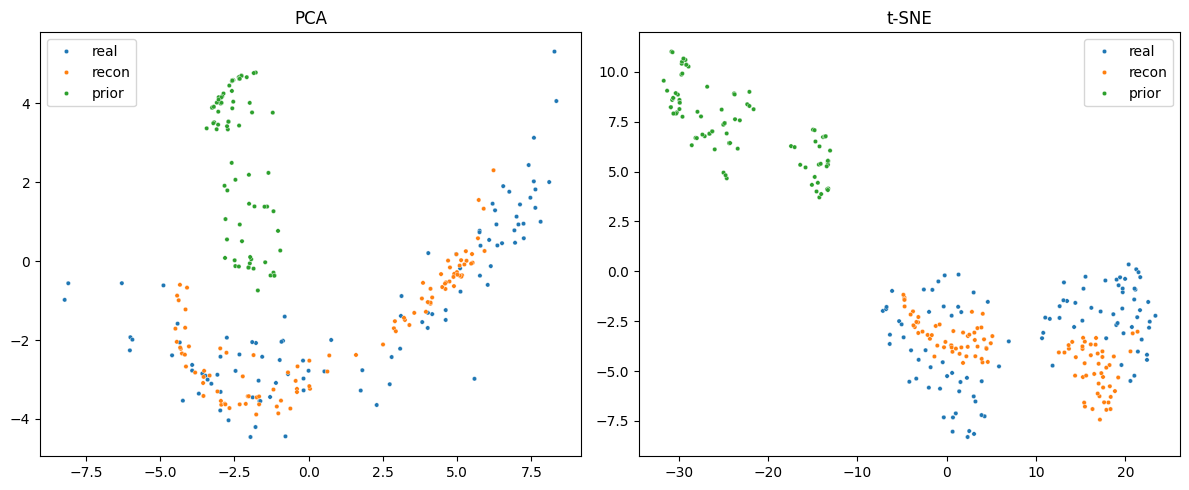

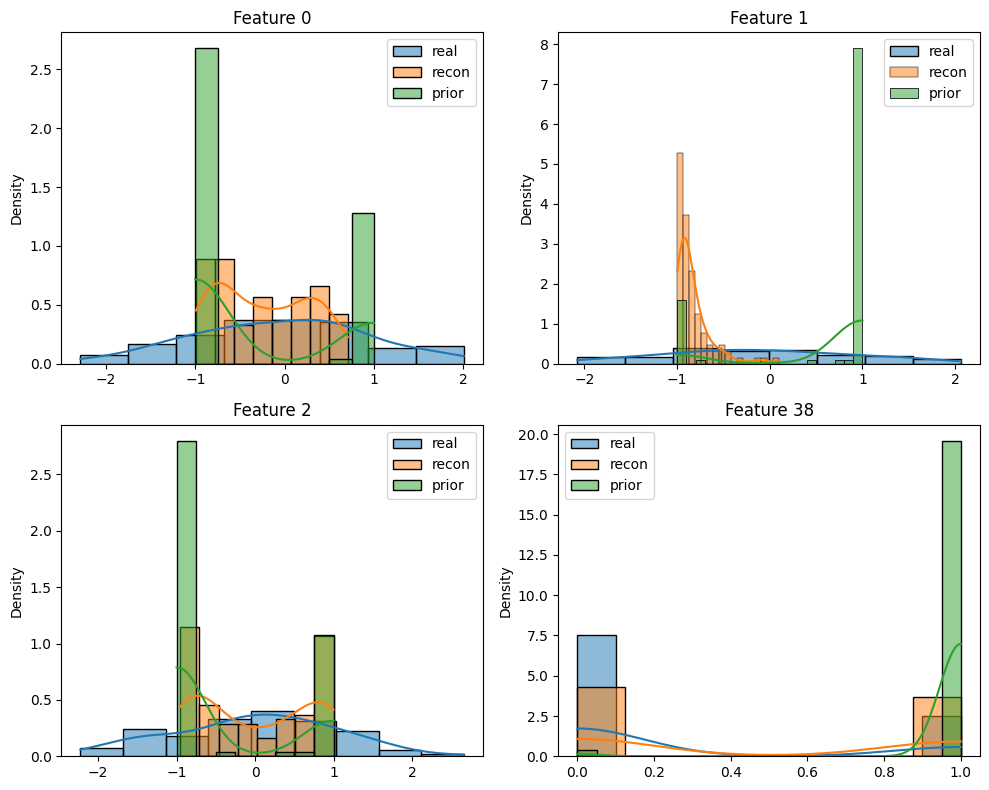

In [20]:
import torch
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

encoder.eval(); decoder.eval()
with torch.no_grad():
    real = next(iter(test_loader)).to(device)
    z_enc, _, _ = encoder(real)
    recon = decoder(z_enc)
    prior = decoder(torch.randn_like(z_enc))

real_np = real.cpu().numpy()
recon_np = recon.cpu().numpy()
prior_np = prior.cpu().numpy()

X = np.vstack([real_np, recon_np, prior_np])
labels = np.array(
    ["real"] * len(real_np) +
    ["recon"] * len(recon_np) +
    ["prior"] * len(prior_np)
)

scaled = StandardScaler().fit_transform(X)

pca = PCA(n_components=2).fit_transform(scaled)
tsne = TSNE(n_components=2, perplexity=30, init="pca").fit_transform(scaled)

fig, ax = plt.subplots(1, 2, figsize=(12, 5))
sns.scatterplot(x=pca[:,0], y=pca[:,1], hue=labels, ax=ax[0], s=10)
ax[0].set_title("PCA")
sns.scatterplot(x=tsne[:,0], y=tsne[:,1], hue=labels, ax=ax[1], s=10)
ax[1].set_title("t-SNE")
plt.tight_layout()

feature_ids = [0, 1, 2, 38]  # pick any feature indices
rows = int(np.ceil(len(feature_ids) / 2))
fig, axes = plt.subplots(rows, 2, figsize=(10, 4 * rows))
axes = axes.flatten()

for ax, idx in zip(axes, feature_ids):
    sns.histplot(real_np[:, idx], label="real", stat="density", color="C0", kde=True, ax=ax)
    sns.histplot(recon_np[:, idx], label="recon", stat="density", color="C1", kde=True, ax=ax)
    sns.histplot(prior_np[:, idx], label="prior", stat="density", color="C2", kde=True, ax=ax)
    ax.set_title(f"Feature {idx}")
    ax.legend()

for ax in axes[len(feature_ids):]:
    ax.remove()

plt.tight_layout()
plt.show()

In [21]:
# Save the model checkpoints
torch.save(encoder.state_dict(), './' + sample_dir + '/encoder.ckpt')
torch.save(decoder.state_dict(), './' + sample_dir + '/decoder.ckpt')
torch.save(discriminator.state_dict(), './' + sample_dir + '/discriminator.ckpt')